# Create dataset which uses HPA metrics as the prediction goal

Summary statistics (filtered):
count    645729.000000
mean      76837.538345
std       73966.411258
min           5.000000
25%       20344.000000
50%       50441.000000
75%      113252.000000
max      320237.000000
Name: latency, dtype: float64
Outliers removed: 57895 out of 703624 (91.77188384705468 % remaining)
CPU
Saved to 04_datasets/qos_4/CPU.feather
Disk_io
Saved to 04_datasets/qos_4/Disk_io.feather
Kepler
Saved to 04_datasets/qos_4/Kepler.feather
Memory
Saved to 04_datasets/qos_4/Memory.feather
Network
Saved to 04_datasets/qos_4/Network.feather
Other
Saved to 04_datasets/qos_4/Other.feather


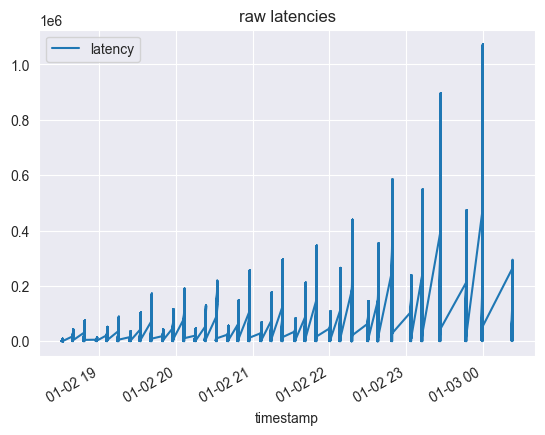

<Axes: title={'center': 'filtered latencies'}, xlabel='timestamp'>

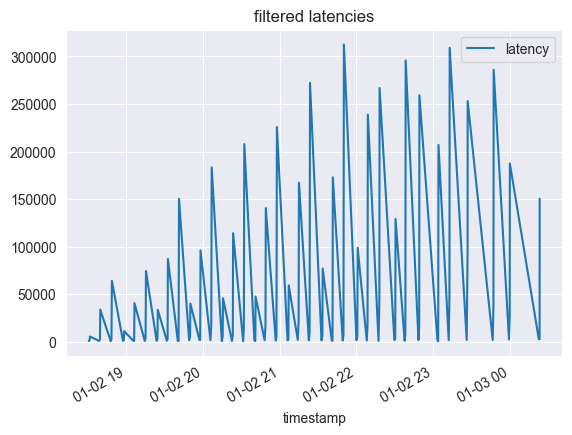

In [31]:
from matplotlib import pyplot as plt
from typing import List
import pandas as pd
import glob
import os

# Path to the directory containing feather files
qos_dir = "../../data/minimized_warehouse_4/"
base_dir = "../../src_predict/03_combined_data/minimized_warehouse_4/"
output_base_dir = "04_datasets/qos_4/"
timezone_difference = 0  # hours (hpa-files and prometheus files were using different timezone for the timestamp


def read_qos_files() -> List[pd.DataFrame]:
    """
    Load the QoS data to dataframes
    cols = ['timestamp', ...]
    """
    qos_files = glob.glob(os.path.join(qos_dir, '**', 'worker_qos.feather'), recursive=True)
    dfs = []
    for qos_path in qos_files:
        qos_df = pd.read_feather(qos_path)
        qos_df["timestamp"] = pd.to_datetime(qos_df["start_time"], unit="ms") - pd.Timedelta(hours=timezone_difference)
        qos_df["latency"] = qos_df["end_time"] - qos_df["start_time"]
        dfs.append(qos_df)
    return dfs

def process_to_intervals(qos_df):
    qos_df_filtered = qos_df.copy()

    # Calculate IQR for latency
    q1 = qos_df_filtered["latency"].quantile(0.25)
    q3 = qos_df_filtered["latency"].quantile(0.75)
    iqr = q3 - q1

    # Define upper and lower bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Filter out outliers
    initial_count = len(qos_df_filtered)
    qos_df_filtered = qos_df_filtered[(qos_df_filtered["latency"] >= lower_bound) & (qos_df_filtered["latency"] <= upper_bound)]
    final_count = len(qos_df_filtered)

    # Print summary statistics and number of outliers removed
    print("Summary statistics (filtered):")
    print(qos_df_filtered["latency"].describe())
    print(f"Outliers removed: {initial_count - final_count} out of {initial_count} ({final_count/initial_count*100} % remaining)")

    # Resample at 5-second intervals
    qos_df_5s_filtered = qos_df_filtered[["timestamp", "latency"]].copy()
    qos_df_5s_filtered = qos_df_5s_filtered.set_index("timestamp").resample("5s").mean().reset_index()
    qos_df_5s_filtered = qos_df_5s_filtered.dropna()
    return qos_df_5s_filtered

qos_dfs = read_qos_files()
qos_df_concat_unfilt = pd.concat(qos_dfs)
qos_df_concat = process_to_intervals(qos_df_concat_unfilt)


def match_qos(df: pd.DataFrame) -> pd.DataFrame:
    """
    Get the HPA metrics with timestamps matched to the given df
    """
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit="s")
    hpa_cols = qos_df_concat.columns
    merged_df = pd.merge_asof(
        df.sort_values(by="timestamp"),
        qos_df_concat.sort_values(by="timestamp"),
        on="timestamp",
        direction="nearest",
        tolerance=pd.Timedelta('5s'),
        suffixes=('_df1', '_df2')
    )
    return merged_df[hpa_cols]


def create_dataset(input_dir, output_path):
    # Initialize an empty list to store individual DataFrames with yolomodel
    dataframes = []

    # Read each feather file
    for file in glob.glob(f"{input_dir}/*.feather"):
        # Read the dataframe
        df = pd.read_feather(file)

        # Add number of workers as a new column
        matched_hpa = match_qos(df)
        df['target'] = matched_hpa["latency"]

        # Remove timestamp column, assuming it's named 'timestamp' as a placeholder
        # df = df.drop(columns=['timestamp']) if 'timestamp' in df.columns else df

        # Append to the list of DataFrames
        dataframes.append(df)

    # Determine common columns across all DataFrames
    common_columns = list(set.intersection(*(set(df.columns) for df in dataframes)))

    # Standardize each DataFrame to have only columns that are common across all DataFrames
    dataframes = [df[common_columns] for df in dataframes]

    # Combine all DataFrames into a single DataFrame
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df.to_feather(output_path)
    print(f"Saved to {output_path}")
    return combined_df


for folder in os.listdir(base_dir):
    print(folder)
    input_dir = os.path.join(base_dir, folder)
    output_path = os.path.join(output_base_dir, f"{folder}.feather")
    create_dataset(input_dir, output_path)

qos_df_concat_unfilt.plot(x="timestamp", y="latency", title="raw latencies")
plt.show()
qos_df_concat.plot(x="timestamp", y="latency", title="filtered latencies")